In [2]:
#%%
import numpy as np
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import numba as nb
import sys
import os

sys.path.insert(0, os.path.realpath('./transport/'))

from transport import tallies
from transport import material_definitions
from transport import functions_for_transport
from transport import functions_for_scattering_theory as xs

from scipy.optimize import minimize


In [3]:
%matplotlib widget

### Match Benchmark
Plot and print out values


Incorrect statement:
"Since the value of ν is 0 for the capture isotope, the total fission cross section is given only by the fission isotope."

In [4]:
resonance_ladder_pu9 = pd.DataFrame({'E'    :   [2.956242e-1], #, 2.5e3, 3e3],
                                'Gn'    :   [7.947046e-5], #, 7.947046e-5, 7.947046e-5],
                                'Gg'    :   [3.982423e-2], #, 3.982423e-2, 3.982423e-2],
                                'Gf'    :   [5.619673e-2]}) #, 5.619673e-2, 5.619673e-2]})

pair_constants_pu9 = {
'ac':0,             # 1e-12cm
'p0':0.002196807122623 * 1/2 ,   # 1 / 1e-12cm - sqrt(eV)
'gj':3/4,
}

resonance_ladder_u8 = pd.DataFrame({'E'    :    [6.674280e0],
                                    'Gn'    :   [1.492300e-3],
                                    'Gg'    :   [2.271100e-2],
                                    'Gf'    :   [9.880000e-9]})

pair_constants_u8 = {
'ac':0,   # 1e-12cm
'p0':0.002196807122623 * 1/2 ,   # 1 / 1e-12cm - sqrt(eV)
'gj':1,
}

Npu9 = 1
Nu8 = 0.124954
Nscat = 0.008340505

pu9 = material_definitions.isotope(pair_constants_pu9, resonance_ladder_pu9, Npu9, 2.88)
u8 = material_definitions.isotope(pair_constants_u8, resonance_ladder_u8, Nu8, 0)

# mat = material_definitions.material([pu9], constant_scattering=1*Nscat)
mat = material_definitions.material([pu9, u8], constant_scattering=20*Nscat)



Text(0.5, 1.0, 'Benchmark CE Transport Cross Sections')

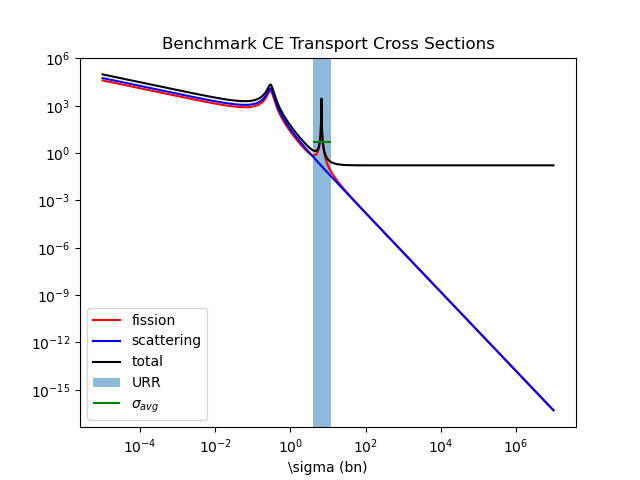

In [56]:
energy = np.logspace(-5,7, 1000)

pu9_Sig_t, pu9_Sig_f, pu9_Sig_g, pu9_Sig_s = pu9.get_macro_cross_sections(energy)
u8_Sig_t, u8_Sig_f, u8_Sig_g, u8_Sig_s = u8.get_macro_cross_sections(energy)

# m_Sig_t, m_Sig_f, m_Sig_g, m_Sig_s = mat.get_macro_cross_sections(energy)
m_Sig_t, m_Sig_f, m_Sig_g, m_Sig_s = mat.get_macro_cross_sections(energy)


URR_Erange = np.array([4,12])
mask = (energy>min(URR_Erange)) & (energy<max(URR_Erange))
xs_avg = [np.mean(m_Sig_t[mask]), np.mean(m_Sig_g[mask]), np.mean(m_Sig_s[mask]), np.mean(m_Sig_f[mask])]

 
figure()
plot(energy, m_Sig_f, color='r', label='fission')
# plot(energy, mat_gam, label='gamma')
plot(energy, m_Sig_s, color='b', label='scattering')
plot(energy, m_Sig_t, color='k', label='total')

# plot(energy, u8_Sig_t, label='U8 total')
# plot(energy, u8_Sig_g, label='U8 cap', color='r')
# plot(energy, u8_Sig_s, label='U8 scat')

axvspan(xmin=min(URR_Erange), xmax=max(URR_Erange), alpha=0.5, label='URR')
hlines(y=xs_avg[1], xmin=min(URR_Erange), xmax=max(URR_Erange), color='g', label=r'$\sigma_{avg}$')

xscale('log'); yscale('log')
xlabel('Energy (eV)')
xlabel(r'\sigma (bn)')
legend()
title('Benchmark CE Transport Cross Sections')

In [6]:
#### problem 4
N = 1.5e2
G = 500
print(f'Particle Histories: {N}')
print(f'Generations: {G}')

Emin = 1e-5
Emax = 2e4 
iEbins = 200
rng = np.random.default_rng()

tally_avg = tallies.tallies(Emin, Emax, iEbins)
tally_avg = functions_for_transport.transport_loop_0D_CE(N, G, tally_avg, mat, rng, URR_Erange, None, xs_avg)
k_avg, kvar_avg, flux_avg = tally_avg.final_analysis() 

tally_res = tallies.tallies(Emin, Emax, iEbins)
tally_res = functions_for_transport.transport_loop_0D_CE(N, G, tally_res, mat, rng, None, None, None)
k_res, kvar_res, flux_res = tally_res.final_analysis() 

print(k_avg, kvar_avg)
print(k_res, kvar_res)

Particle Histories: 150.0
Generations: 500


KeyboardInterrupt: 

2.1624666666666665 0.004445239185233906
1.0072533333333333 0.004987950352565825


Text(0, 0.5, 'Flux per unit E')

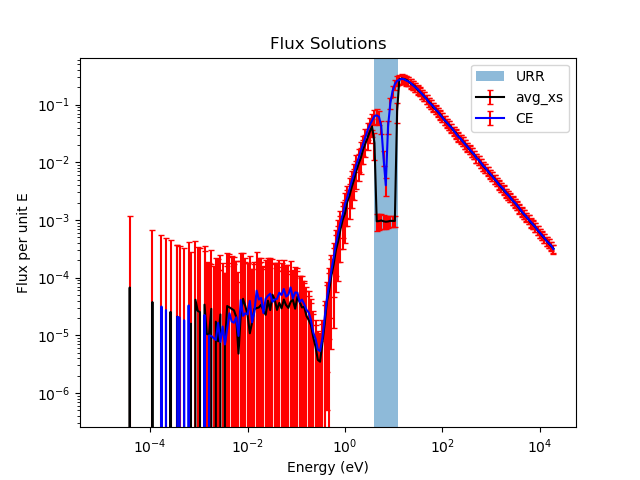

In [ ]:
print(k_avg, kvar_avg)
print(k_res, kvar_res)
figure()
errorbar(tally_avg.Ebins, flux_avg[0], yerr=np.sqrt(flux_avg[1]), 
                                                            fmt='-', color='k', ms=8, ecolor='r', capsize=2,
                                                            label='avg_xs')
errorbar(tally_res.Ebins, flux_res[0], yerr=np.sqrt(flux_res[1]), 
                                                            fmt='-', color='b', ms=2, ecolor='r', capsize=2,
                                                            label='CE')
axvspan(xmin=min(URR_Erange), xmax=max(URR_Erange), alpha=0.5, label='URR')
xscale('log')
yscale('log')
legend()
title('Flux Solutions')
xlabel('Energy (eV)')
ylabel('Flux per unit E')

## Sample a URR Ladder
For Pu-239
For U238, the URR occurs from 20 keV to just above 149 keV. 
Let's start simple, get rid of the Pu-239 isotope and do the following:
1. Take a reference point $E_{ref}$ = 100 keV
2. Generate resonance-pair sequences out to either side of $E_{ref}$ and reconstruct the Fission, Capture, and Elastic scattering cross sections. (Make a nice plot!)
3. Use the Dyson-Mehta $\Delta_3$ statistic to terminate the end of the simulated resonance ladder

In [42]:
np.random.default_rng(3).chisquare(1, size=3)

array([0.01467156, 1.84835582, 0.0177204 ])

             E        Gn        Gg         Gf
0   985.232243  0.136882  0.022711   2.766026
1  1005.232243  0.014672  0.022711  10.102125
             E        Gn        Gg         Gf
0   955.292868  1.980201  0.022711   1.549928
1   985.232243  0.136882  0.022711   2.766026
2  1005.232243  0.014672  0.022711  10.102125
3  1019.002343  1.848356  0.022711   3.358080
             E        Gn        Gg         Gf
0   964.557116  0.748348  0.022711   8.780203
1   974.733109  1.980201  0.022711   1.549928
2   985.232243  0.136882  0.022711   2.766026
3  1005.232243  0.014672  0.022711  10.102125
4  1028.933698  1.848356  0.022711   3.358080
5  1055.173711  0.017720  0.022711   1.485733
             E        Gn        Gg         Gf
0   934.838408  0.070614  0.022711   1.698576
1   948.201945  0.748348  0.022711   8.780203
2   967.034810  1.980201  0.022711   1.549928
3   985.232243  0.136882  0.022711   2.766026
4  1005.232243  0.014672  0.022711  10.102125
5  1024.772820  1.848356  0.022711

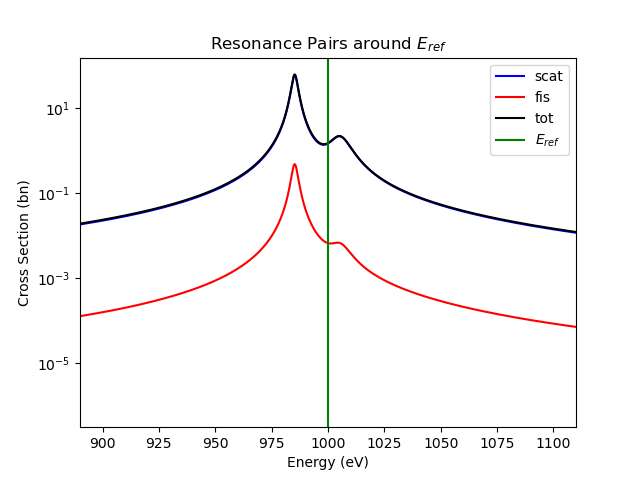

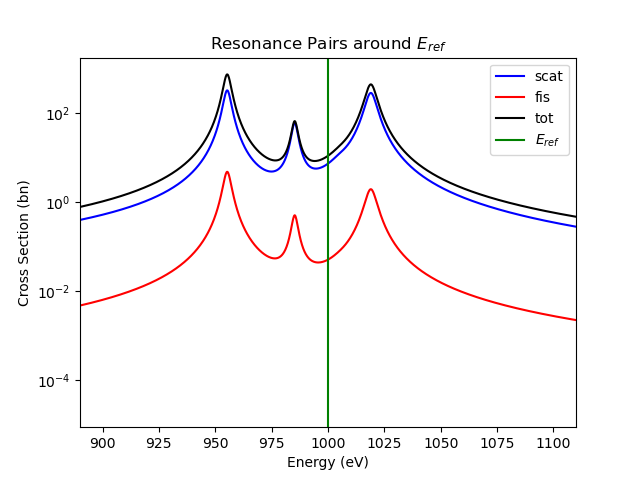

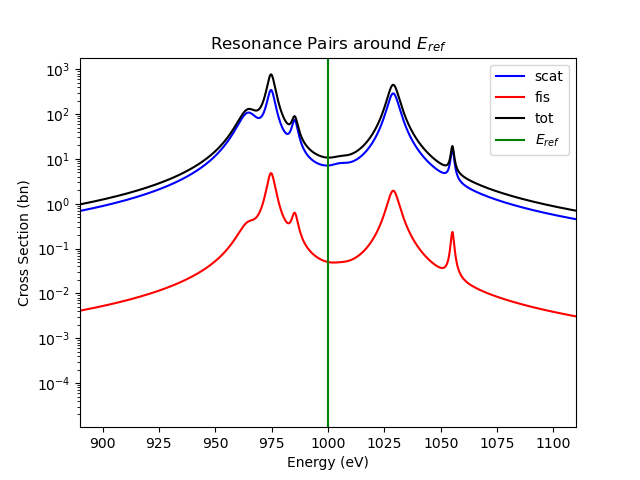

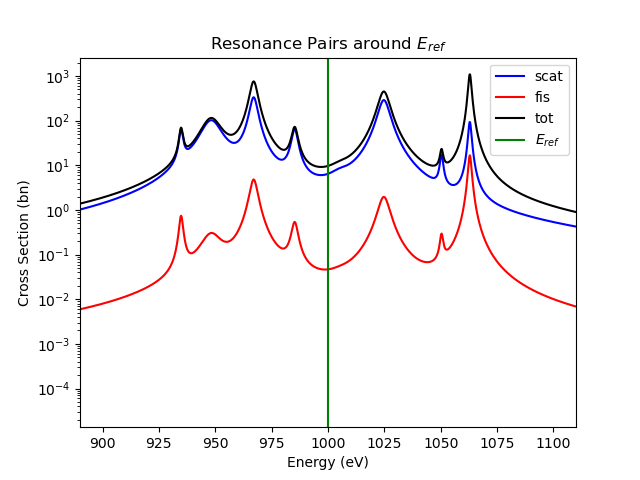

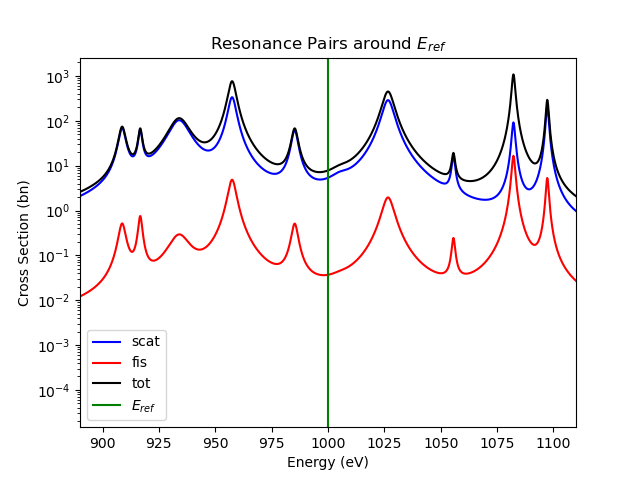

In [53]:

u8_Sig_t, u8_Sig_f, u8_Sig_g, u8_Sig_s = u8.get_macro_cross_sections(energy)

D_avg = 20
Gn_avg = 1.492300e-3
Gg_avg = 2.271100e-2
Gf_avg = 9.880000e-9


def sample_spacing(D):
    spacing = np.sqrt(-4/np.pi*np.log( np.random.default_rng().uniform(low=0.0,high=1.0,size=2) ))
    return spacing*D

def calculate_D3_statistic(E_levels):
    Ef = E_levels[-1]
    Ei = E_levels[0]
    N = []
    Erange = np.linspace(Ei, Ef, 100)
    for El in Erange:
        test = 0
        N.append(np.count_nonzero(np.array(E_levels)[E_levels<El]))
    def linear(vars):
        return vars[0]*Erange+vars[1]
    def fit(vars):
        return np.sum( (linear(vars) - np.array(N))**2)
    out = minimize(fit, x0=(1e3,0))
    D3 = out.fun/2/len(E_levels)
    D3_theo = 1/np.pi**2 * np.log(len(E_levels)-0.06871) 
    print(f'The final D3 statistic and theoretical value are {D3} and {D3_theo}')
    return

def get_resonance_ladder(E_ref, resonance_pairs,
                         seed = None):

    pairs = 0
    rn = np.random.default_rng(seed).uniform(low=0.0,high=1.0)

    El_pos = [E_ref+rn*D_avg]
    El_neg = [E_ref+(rn-1)*D_avg]
    E_levels = El_neg + El_pos

    while pairs < resonance_pairs:
        spacing = sample_spacing(D_avg)
        El_neg.insert(0, El_neg[0]-spacing[0])
        El_pos.append(El_pos[-1]+spacing[1])
        E_levels = El_neg + El_pos
        # calculate D3 statistic to determine when to stop
        pairs += 1

    # sample reaction widths
    # Gg = np.random.chisquare(1000, size=len(E_levels))
    Gg = np.array([Gg_avg]*len(E_levels))
    Gn_neg = np.random.default_rng(seed).chisquare(1, size=len(El_neg))
    Gf_neg = np.random.default_rng(seed).chisquare(3, size=len(El_neg))
    Gn_pos = np.random.default_rng(seed+1).chisquare(1, size=len(El_pos))
    Gf_pos = np.random.default_rng(seed+1).chisquare(3, size=len(El_pos))
    Gn = np.concatenate([np.flipud(Gn_neg),Gn_pos])
    Gf = np.concatenate([np.flipud(Gf_neg),Gf_pos])
    
    E_levels = np.array(E_levels)
    # calculate_D3_statistic(E_levels)
    ladder = pd.DataFrame({'E'    :    E_levels,
                            'Gn'    :   Gn,
                            'Gg'    :   Gg,
                            'Gf'    :   Gf})
    
    return ladder

def calculate_xs_history(energy_grid, E_ref, isotope):
    rxns = isotope.get_macro_cross_sections(energy_grid)
    u8_Sig_t, u8_Sig_f, u8_Sig_g, u8_Sig_s = [np.unique(each[energy_grid==E_ref]) for each in rxns] 
    # np.unique([energy_grid==E_ref]) tot, cap, scat, fis
    return u8_Sig_t, u8_Sig_g, u8_Sig_s, u8_Sig_f
    


Ebins = np.array([1000])#*1e3
vEbins = np.array([100,2000])#*1e3
# for E ref in Ebins if I want to build a ptable for multiple energy bins
E_ref = Ebins[0]
# URR_energy = np.linspace(20e3, 149e3, 10000) # full URR range for U8
URR_energy = np.concatenate( [np.linspace(min(vEbins), E_ref, 5000), np.linspace(E_ref, max(vEbins), 5000)] )


for i in range(5):
    # sample history
    u8_URR_ladder = get_resonance_ladder(E_ref, i, seed=2)
    u8_URR = material_definitions.isotope(pair_constants_u8, u8_URR_ladder, Nu8, 0)
    if np.any(u8_URR_ladder.E <0):
        raise ValueError("negative resonance sampled")
    print(u8_URR_ladder)              
    # u8_URR.get_macro_cross_sections(URR_energy)
    u8_Sig_t_Eref_hist, u8_Sig_f_Eref_hist, u8_Sig_g_Eref_hist, u8_Sig_s_Eref_hist = calculate_xs_history(URR_energy, E_ref, u8_URR)
    # print(u8_Sig_t_Eref_hist, u8_Sig_f_Eref_hist, u8_Sig_g_Eref_hist, u8_Sig_s_Eref_hist)

    # reconstruct U8 and material cross section for plotting
    u8_Sig_t, u8_Sig_f, u8_Sig_g, u8_Sig_s = u8_URR.get_macro_cross_sections(URR_energy)
    mat_wURR = material_definitions.material([pu9,u8, u8_URR], constant_scattering=1*Nscat)
    m_Sig_t, m_Sig_f, m_Sig_g, m_Sig_s = mat_wURR.get_macro_cross_sections(energy)


    figure()
    # plot(energy, m_Sig_t, label='total mat', color='b')
    # plot(energy, m_Sig_f, label='fis', color='r')
    # plot(energy, m_Sig_g, label='cap', color='orange')
    # plot(energy, m_Sig_s, label='scat', color='k')

    # plot(URR_energy, u8_Sig_g, color='orange')
    plot(URR_energy, u8_Sig_s, color='b', label='scat')
    plot(URR_energy, u8_Sig_f, color='r', label='fis')
    plot(URR_energy, u8_Sig_t, color='k', label='tot')
    axvline(E_ref, label=r'$E_{ref}$', color='g')
    # xscale('log')
    yscale('log')
    legend()

    xlim([890,1110])
    xlabel('Energy (eV)'); ylabel('Cross Section (bn)')
    title(r'Resonance Pairs around $E_{ref}$')
    savefig(f'/Users/noahwalton/Library/Mobile Documents/com~apple~CloudDocs/References/NE 697 Advanced Transport Methods/URR Project/figures/addres_{i}.png')

# len(URR_energy[u8_Sig_t<u8_Sig_f])
# print(u8_Sig_g[URR_energy==E_ref])
# print(f'Min/Max of total: {min(u8_Sig_t)}/{max(u8_Sig_t)}')

In [11]:
u8_URR_ladder

,E,Gn,Gg,Gf
0,970.840172,0.368449,0.022711,3.440458
1,998.131509,1.421821,0.022711,2.097610
2,1018.131509,0.234336,0.022711,5.396599
3,1034.526791,0.197454,0.022711,1.984078


## Test transport with URR Resonance

Takes forever because I am calculating the cross section each time (looping over all resonances in the URR). Need to calculate before hand, store, and interpolate.

In [8]:
# # test
# N = 1.5e1
# G=2
# iE = 200
# print(f'Particle Histories: {N}')
# print(f'Energy Bins: {iE}')

# Emin = 1e-5
# Emax = 2e7 
# iEbins = 200
# tally = tallies.tallies(Emin, Emax, iEbins)

# # option to set seed
# rng = np.random.default_rng()

# for g in range(int(G)):

#     tally.reset_generation_tally()
    
#     for iN in range(int(N)):
#         #random fission energy
#         E_start = rng.uniform(low=tally.Emin, high=tally.Emax) 
#         # transport
#         E_new = functions_for_transport.Eigen_function_0D_CE(E_start, tally, mat_wURR, rng)
    
#     # save generation tally
#     tally.save_generation_tally(N)
    
   
# final_k_estimate, final_estimator_variance, collision_based_scalar_flux = tally.final_analysis() 

# print(final_k_estimate, final_estimator_variance)

### Now tally the cross section at E_reference

Notes:
- min and max cross section bounds are actually determined after the MC simulation
- the bin structure and tallying is actually done only on the total cross section! i.e. the band selection for the partial reactions is based on the band selection for the total cross section
- For one batch
    - the average cross section in the band is calculated as the sum of all cross section samples that fall within the band divided by the number of tallies that band got
    - the probabilty of the band is calculated as the number of tallies the band got divided by the total number of histories in the batch
- Then, the 'grand mean' is calculated using each of the batches

In [9]:
def setup_reaction_xs_bins(minxs, maxxs, ibins):
    vbins = np.linspace(minxs, maxxs,ibins+1) #edges
    dbins = np.zeros(len(vbins)-1)
    bins = np.zeros(len(vbins)-1) # midpoints
    for i in range(1,len(vbins)):
        dbins[i-1] = vbins[i] - vbins[i-1] 
        bins[i-1] = (vbins[i]+vbins[i-1])/2 
    return bins, vbins

def determine_bindex(sigma, vBins):
    assert len(sigma) == 1
    bindex = np.searchsorted(vBins, sigma)
    return bindex

def tally_rxn(tally, sigma, bindex):
    assert len(sigma) == 1
    tally[0, bindex] += sigma
    tally[1, bindex] += sigma**2
    return tally


TotBins, vTotBins = setup_reaction_xs_bins(1e1, 2.5e2, 4)

# figure()
# for each in vTotBins:
#     axhline(each, color='b')
# for each in vFisBins:
#     axhline(each, color='r')


### Generate PTable

In [10]:
batches = 2
histories = 200

TotTally = np.zeros((batches,len(TotBins)+2))
CapTally = np.zeros((batches,len(TotBins)+2))
ScatTally = np.zeros((batches,len(TotBins)+2))
FisTally = np.zeros((batches,len(TotBins)+2))
PTally = np.zeros((batches,len(TotBins)+2))
rxn_means = np.zeros((1,4))

for ibatch in range(batches):

    # tally containers for history 
    tally_list = [np.zeros((2,len(TotBins)+2)) for i in range(4)]
    ptally = np.zeros((1,len(TotBins)+2))

    for ihist in range(histories):

        # sample a xs history at E_ref
        u8_URR_ladder = get_resonance_ladder(E_ref, 40)
        u8_URR = material_definitions.isotope(pair_constants_u8, u8_URR_ladder, Nu8, 0)
        tot, cap, scat, fis = calculate_xs_history(URR_energy, E_ref, u8_URR)
        # if np.any(np.isnan([tot, cap, scat, fis])):
        #     pass
        [tot, cap, scat, fis] = [np.nan_to_num(rxn) for rxn in [tot, cap, scat, fis]]
        rxn_means += np.array([tot, cap, scat, fis]).T

        # tally probability table determined by total xs and reaction xs
        bindex = determine_bindex(tot, vTotBins)
        sigma_list = [tot, cap, scat, fis]
        tally_list = [tally_rxn(rxn_tally, rxn_sigma, bindex) for rxn_tally, rxn_sigma in zip(tally_list, sigma_list)]
        ptally[0, bindex] += 1

    # calculate mean and store for batch
    PTally[ibatch, :] = ptally[0, :]/np.sum(ptally)
    batch_avg_list  = [rxn_tally[0,:]/ptally for rxn_tally in tally_list]
    # if np.any(np.isnan(batch_avg_list[0])):
    #     pass
    # batch_avg_list = [np.nan_to_num(rxn_tally[0,:]) for rxn_tally in tally_list]
    TotTally[ibatch, :] = batch_avg_list[0]
    # print(tally_list[0][0,:])
    # print(ptally)
    # print(TotTally)
    CapTally[ibatch, :] = batch_avg_list[1]
    ScatTally[ibatch, :] = batch_avg_list[2]
    FisTally[ibatch, :] = batch_avg_list[3]

# total mean cross section at E_ref
rxn_means = rxn_means/(batches*histories)

/Users/noahwalton/Documents/GitHub/neutron_transport/transport/functions_for_scattering_theory.py:22: RuntimeWarning: invalid value encountered in sqrt
  return Gn*np.sqrt(E/Elam)


In [11]:
PTable = np.array([np.mean(PTally, axis=0), np.std(PTally, axis=0)])
TotTable = np.array([np.mean(TotTally, axis=0), np.std(TotTally, axis=0)])
CapTable = np.array([np.mean(CapTally, axis=0), np.std(CapTally, axis=0)])
ScatTable = np.array([np.mean(ScatTally, axis=0), np.std(ScatTally, axis=0)])
FisTable = np.array([np.mean(FisTally, axis=0), np.std(FisTally, axis=0)])

print(PTable)
print(TotTable)
print(np.average(TotTable[0], weights = PTable[0]))
print(rxn_means[0,0])

[[0.0975 0.5275 0.155  0.0675 0.025  0.1275]
 [0.0125 0.0075 0.025  0.0125 0.005  0.0125]]
[[6.47981297e+00 3.29333035e+01 9.72701123e+01 1.59175272e+02
  2.17753147e+02 4.71027554e+02]
 [1.49913975e-01 1.29440330e-01 2.01660435e-01 5.96346789e+00
  5.06922761e+00 1.33812071e+00]]
109.32513941358096
109.28672407872644


# Now run transport using probability tables

In [12]:
ptables_list = [PTable, TotTable, CapTable, ScatTable, FisTable]
URR_Erange = np.array([20,149*1e3])
avg_URR_xs = rxn_means.flatten()
print(avg_URR_xs)
print(TotTable)
vEbins

[109.28672408   0.62863128  54.70233557  53.95575723]
[[6.47981297e+00 3.29333035e+01 9.72701123e+01 1.59175272e+02
  2.17753147e+02 4.71027554e+02]
 [1.49913975e-01 1.29440330e-01 2.01660435e-01 5.96346789e+00
  5.06922761e+00 1.33812071e+00]]


array([ 100, 2000])

In [13]:
#### problem 4
N = 1.5e2
G = 500
print(f'Particle Histories: {N}')
print(f'Generations: {G}')

Emin = 1e-5
Emax = 2e7 
iEbins = 200
rng = np.random.default_rng()

# tally_avg = tallies.tallies(Emin, Emax, iEbins)
tally_avg = functions_for_transport.transport_loop_0D_CE(N, G, tally_avg, mat, rng, URR_Erange, None, avg_URR_xs)
k_avg, kvar_avg, flux_avg = tally_avg.final_analysis() 

# tally_ptables = tallies.tallies(Emin, Emax, iEbins)
tally_ptables = functions_for_transport.transport_loop_0D_CE(N, G, tally_ptables, mat, rng, URR_Erange, ptables_list, None)
k_ptables, kvar_ptables, flux_ptables = tally_ptables.final_analysis() 

print(k_avg, kvar_avg)
print(k_ptables, kvar_ptables)

Particle Histories: 150.0
Generations: 500


NameError: name 'tally_ptables' is not defined

In [ ]:
# import SPiderFighTer
print(k_avg, kvar_avg)
print(k_ptables, kvar_ptables)

1.0041333333333333 0.003349519034725902
0.998721212121212 0.0034834666890678494


Text(0, 0.5, 'Flux per unit E')

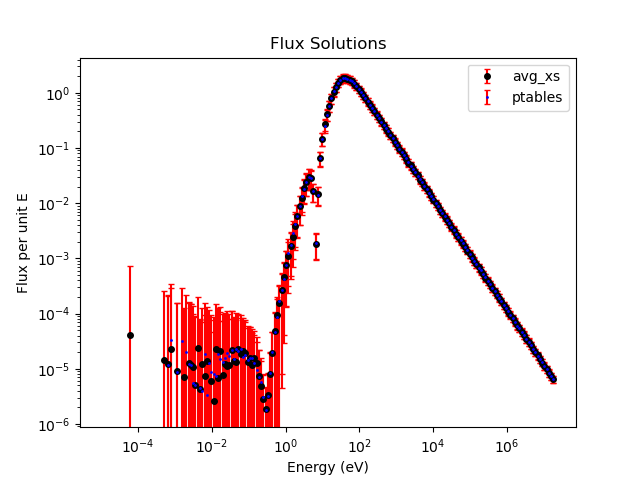

In [ ]:
# %%
figure()
errorbar(tally_avg.Ebins, flux_avg[0], yerr=np.sqrt(flux_avg[1]), 
                                                            fmt='.', color='k', ms=8, ecolor='r', capsize=2,
                                                            label='avg_xs')
errorbar(tally_ptables.Ebins, flux_ptables[0], yerr=np.sqrt(flux_ptables[1]), 
                                                            fmt='.', color='b', ms=2, ecolor='r', capsize=2,
                                                            label='ptables')

xscale('log')
yscale('log')
legend()
title('Flux Solutions')
xlabel('Energy (eV)')
ylabel('Flux per unit E')

Text(0, 0.5, 'Difference')

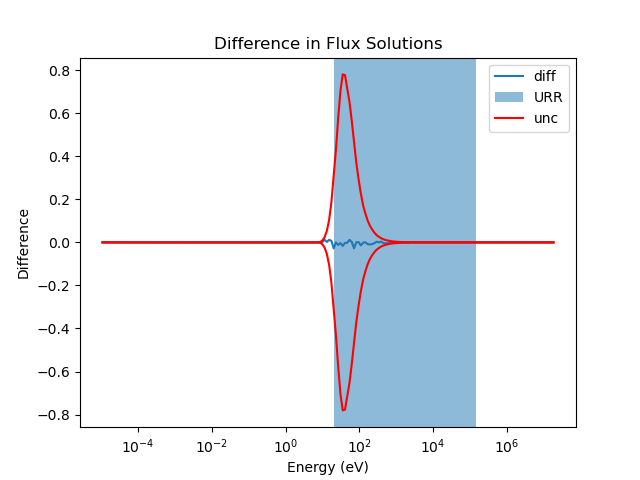

In [ ]:
figure()
plot(tally_avg.Ebins, flux_avg[0]-flux_ptables[0], label='diff')
xscale('log')
axvspan(xmin=min(URR_Erange), xmax=max(URR_Erange), alpha=0.5, label='URR')

err_diff = np.sqrt( flux_avg[1]*(-flux_ptables[0])**2 + flux_ptables[1]*(flux_avg[0])**2 )
plot(tally_avg.Ebins, 0-err_diff, color='r')
plot(tally_avg.Ebins, 0+err_diff, color='r', label='unc')

xscale('log')
legend()
title('Difference in Flux Solutions')
xlabel('Energy (eV)')
ylabel('Difference')


#### Need to figure out the dyson mehta statistic for when to quit sampling resonances!

In [ ]:
# # calculate D3 statistic

# Ef = E_levels[-1]
# Ei = E_levels[0]
# N = []
# Erange = np.linspace(Ei, Ef, 100)
# for El in Erange:
#     test = 0
#     N.append(np.count_nonzero(np.array(E_levels)[E_levels<El]))

# figure()
# plot(Erange,N)
# # xscale('log')

# def linear(vars):
#     return vars[0]*Erange+vars[1]
# def fit(vars):
#     return np.sum( (linear(vars) - np.array(N))**2/np.diff(Erange)[0])

# from scipy.optimize import minimize
# out = minimize(fit, x0=(1e3,0))

# print(out.fun/2/len(E_levels))
# print(1/np.pi**2 * np.log(len(E_levels)-0.06871) )

# plot(Erange, linear(out.x))
